### 0. Import util libraries

In [1]:
import numpy as np
import torch
torch.manual_seed(123)
from scipy import interpolate
import random
from scipy.integrate import solve_ivp

# helmholtz gp imports
import helmholtz_gp.helmholtz_regression_pytorch as hrp
import helmholtz_gp.plot_helper_arxiv as plot_helm
from helmholtz_gp.parameters import TwoKernelGPParams
from helmholtz_gp.optimization_loop import basic_optimization_loop

# d-hnn imports
import dissipative_hnns
from dissipative_hnns.models import MLP, DHNN, HNN
from dissipative_hnns.train import train, get_args

# set plotting params for the notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [20, 10]
mpl.rcParams['figure.dpi'] = 300
np.set_printoptions(precision=5)
from matplotlib import cm
plt.rcParams.update(
        {
            "text.usetex": True,
            "font.family": "serif",
            "font.serif": ["Times"],
            "font.size": 12,
        }
    )

### 1. Import the data

In [2]:
X_grid = np.genfromtxt('../data/Xgrid_laserfull.csv', delimiter=',')
Y_grid = np.genfromtxt('../data/Ygrid_laserfull.csv', delimiter=',')
XY_train = torch.from_numpy(np.genfromtxt('../data/XY_train_laserfull.csv', delimiter=','))
XY_test = torch.from_numpy(np.genfromtxt('../data/XY_test_laserfull.csv', delimiter=','))
UV_train = torch.from_numpy(np.genfromtxt('../data/UV_train_laserfull.csv', delimiter=','))

### 2. Visualize the data

We first visualize the imported data. Here we just have the velocity field. 

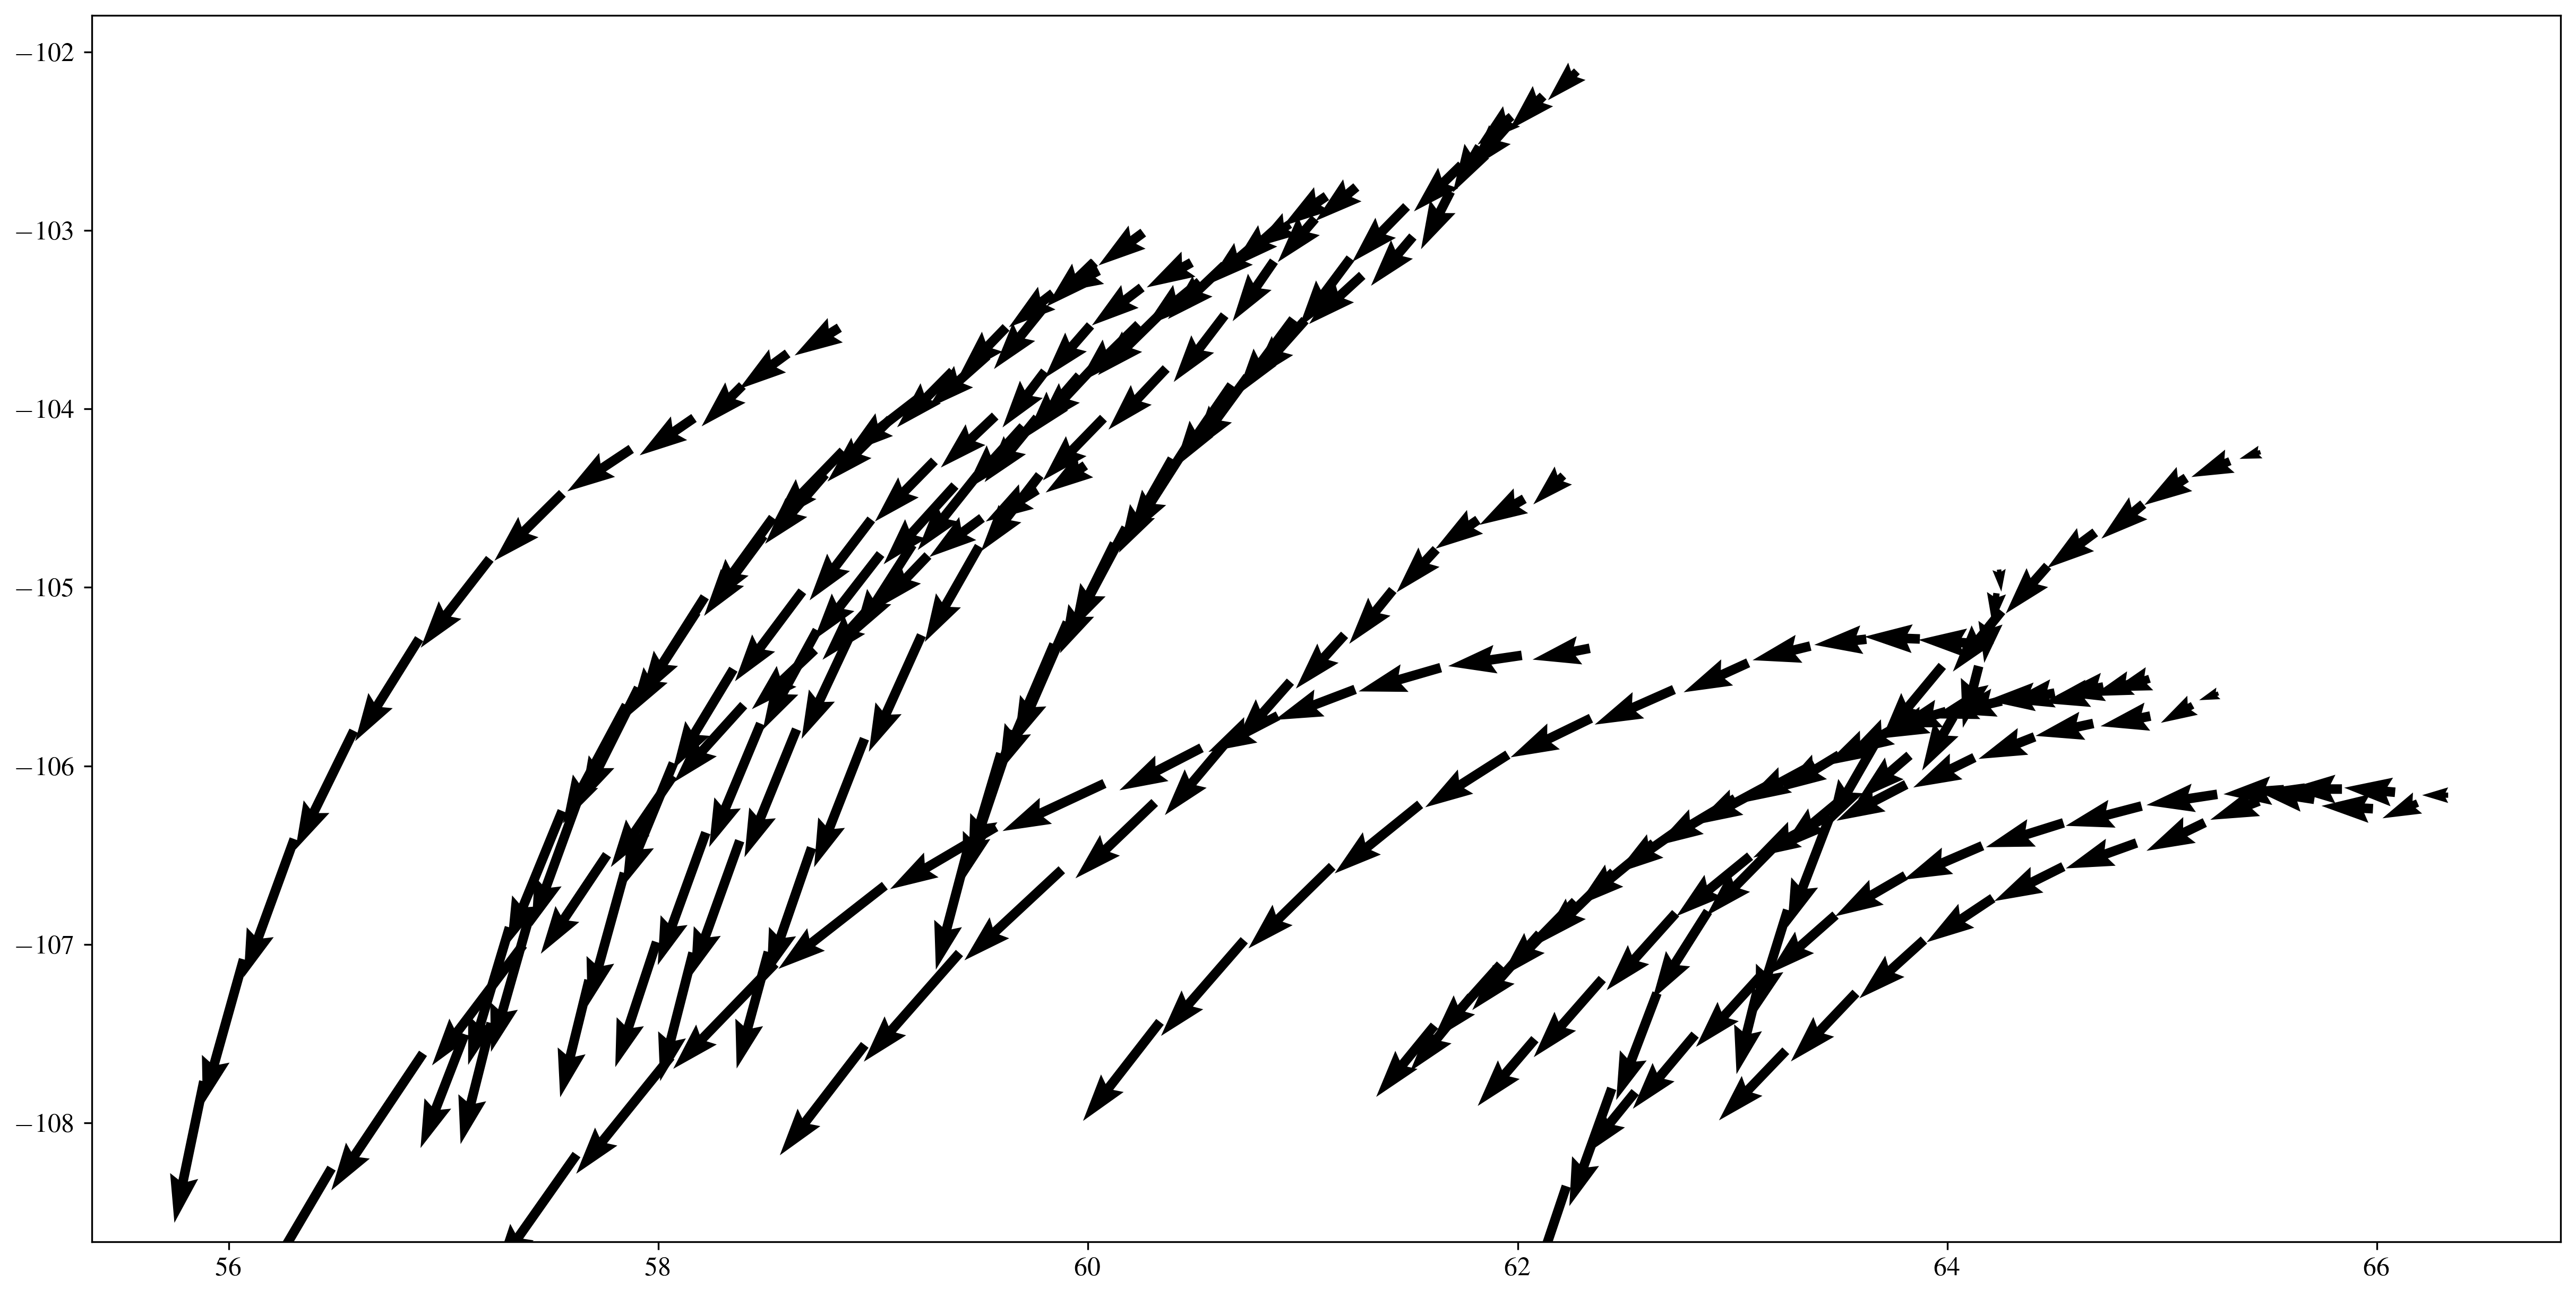

In [3]:
plt.quiver(XY_train[:,0], XY_train[:,1], UV_train[:,0], UV_train[:,1])

### 3. Fit the Helmholtz GP 

We first fit the Helmholtz GP. The parameters are optimized on the log-scale, as follows. The loss function is the negative log-likelihood of the training points. 

Optimizer for GP:

In [4]:
log_ls_Phi = torch.tensor(0., requires_grad=True) 
log_sigma_Phi = torch.tensor(0., requires_grad=True)
log_ls_A = torch.tensor(1., requires_grad=True)
log_sigma_A = torch.tensor(-1., requires_grad=True) 
log_obs_noise_helm = torch.tensor(-2., requires_grad=True)

params_helm = [log_ls_Phi,log_sigma_Phi,log_ls_A,log_sigma_A,log_obs_noise_helm]
params_helm = TwoKernelGPParams(*params_helm)

def loss_helm(params_helm):
    return -hrp.posterior_kernel_twodata(XY_test, XY_test, UV_train, XY_train, kind = "helmholtz", params=params_helm)[2][0,0]

In [5]:
basic_optimization_loop(loss_helm, params_helm)

At step 0, loss: -744.2804952171157
At step 100, loss: -1292.8891667120674
At step 200, loss: -1425.6160396938883
At step 300, loss: -1427.6939297915244
At step 400, loss: -1429.0934974897582
At step 500, loss: -1430.7697960374749
At step 600, loss: -1432.812033980047
At step 700, loss: -1434.9296350473858
At step 800, loss: -1436.6957457870433
At step 900, loss: -1437.8499702292354
At step 1000, loss: -1438.4377593892787
At step 1100, loss: -1438.6754845819369
At step 1200, loss: -1438.7543073666134
At step 1300, loss: -1438.7763725254965


We can show the optimal parameters:

In [6]:
best_params_helm = params_helm.get_params()
best_params_helm

[tensor(1.5458, grad_fn=<ExpBackward0>),
 tensor(0.0477, grad_fn=<ExpBackward0>),
 tensor(11.3697, grad_fn=<ExpBackward0>),
 tensor(1.4015, grad_fn=<ExpBackward0>),
 tensor(0.0270, grad_fn=<ExpBackward0>)]

We visualize the predicted mean and covariance:

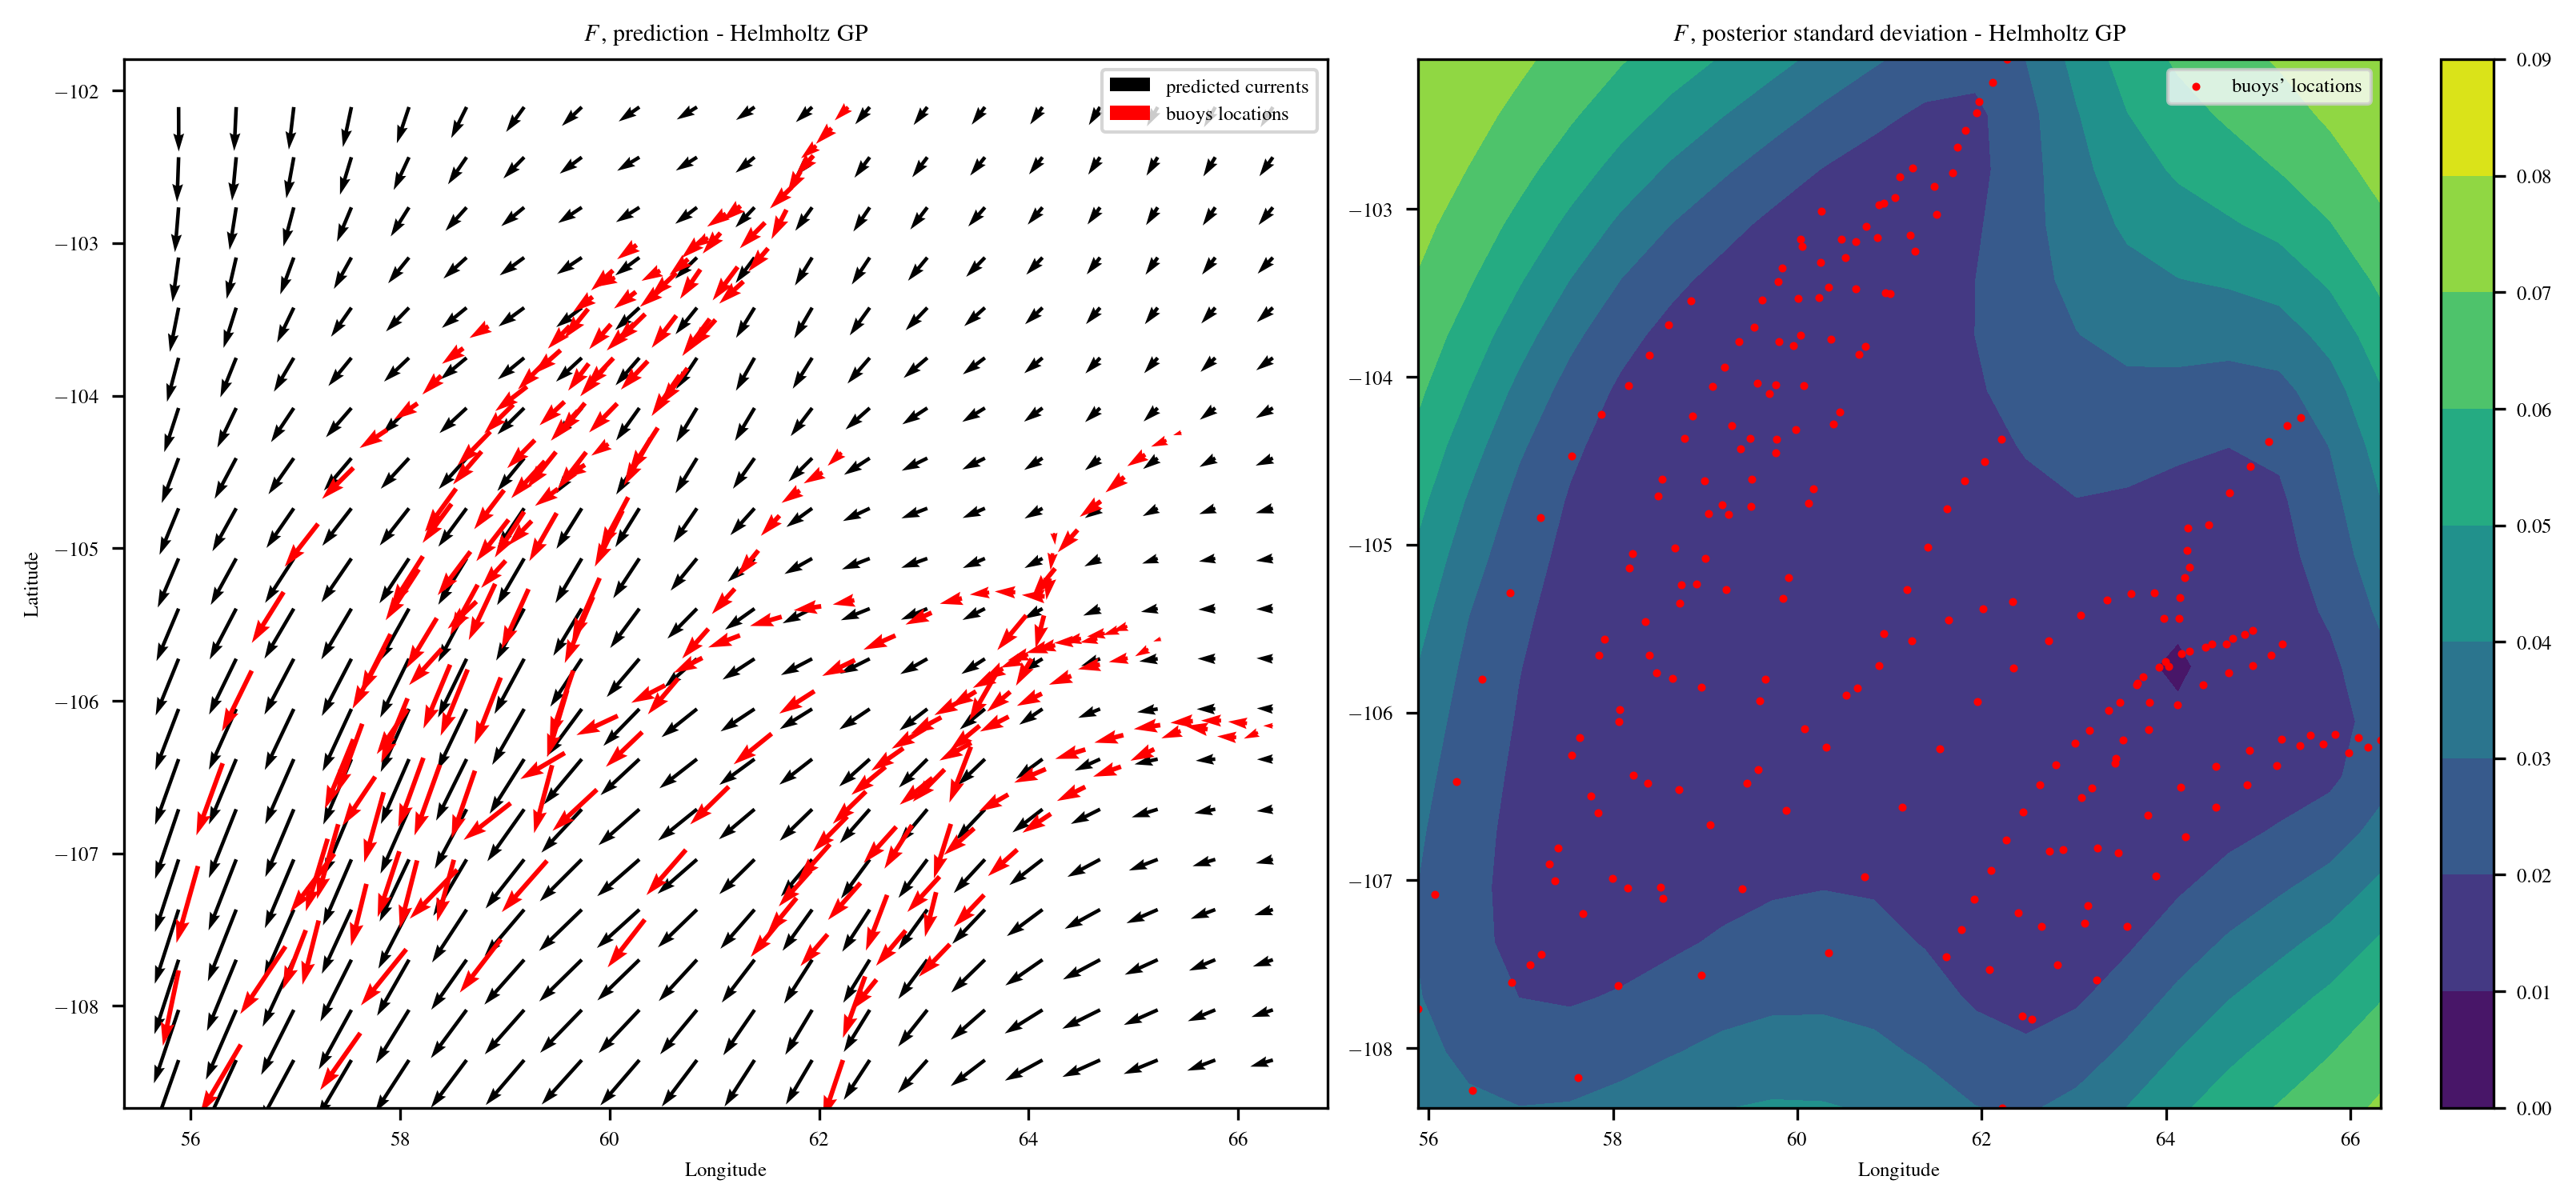

In [29]:
opt_post_mean_helm, opt_post_cov_helm, opt_ll_helm = hrp.posterior_kernel_twodata(XY_test, XY_test, UV_train, XY_train, "helmholtz", params_helm)

plot_helm.plot_results_grid(X_grid, Y_grid, XY_train, UV_train, opt_post_mean_helm, opt_post_cov_helm, levels="", scale=0.5, method="Helmholtz GP")


### 4. Fit velocity GP regression

We then fit the velocity GP, in a similar way.

In [8]:
log_ls_u = torch.tensor(0., requires_grad=True) 
log_sigma_u = torch.tensor(0., requires_grad=True)
log_ls_v = torch.tensor(1., requires_grad=True)
log_sigma_v = torch.tensor(-1., requires_grad=True) 
log_obs_noise_uv = torch.tensor(-2., requires_grad=True)

params_uv = [log_ls_u,log_sigma_u,log_ls_v,log_sigma_v,log_obs_noise_uv]
params_uv = TwoKernelGPParams(*params_uv)

def loss_uv(params_uv):
    return -hrp.posterior_kernel_twodata(XY_test, XY_test, UV_train, XY_train, kind = "standard", params=params_uv)[2][0,0]

In [9]:
basic_optimization_loop(loss_uv, params_uv)

At step 0, loss: -781.0832584626886
At step 100, loss: -1288.2109641296029
At step 200, loss: -1420.471356728365
At step 300, loss: -1427.7831669372085
At step 400, loss: -1432.8838013748184
At step 500, loss: -1434.8562350093541
At step 600, loss: -1435.1070637558637


In [10]:
best_params_uv = params_uv.get_params()
best_params_uv

[tensor(1.8306, grad_fn=<ExpBackward0>),
 tensor(0.0772, grad_fn=<ExpBackward0>),
 tensor(2.7183, grad_fn=<ExpBackward0>),
 tensor(0.0999, grad_fn=<ExpBackward0>),
 tensor(0.0261, grad_fn=<ExpBackward0>)]

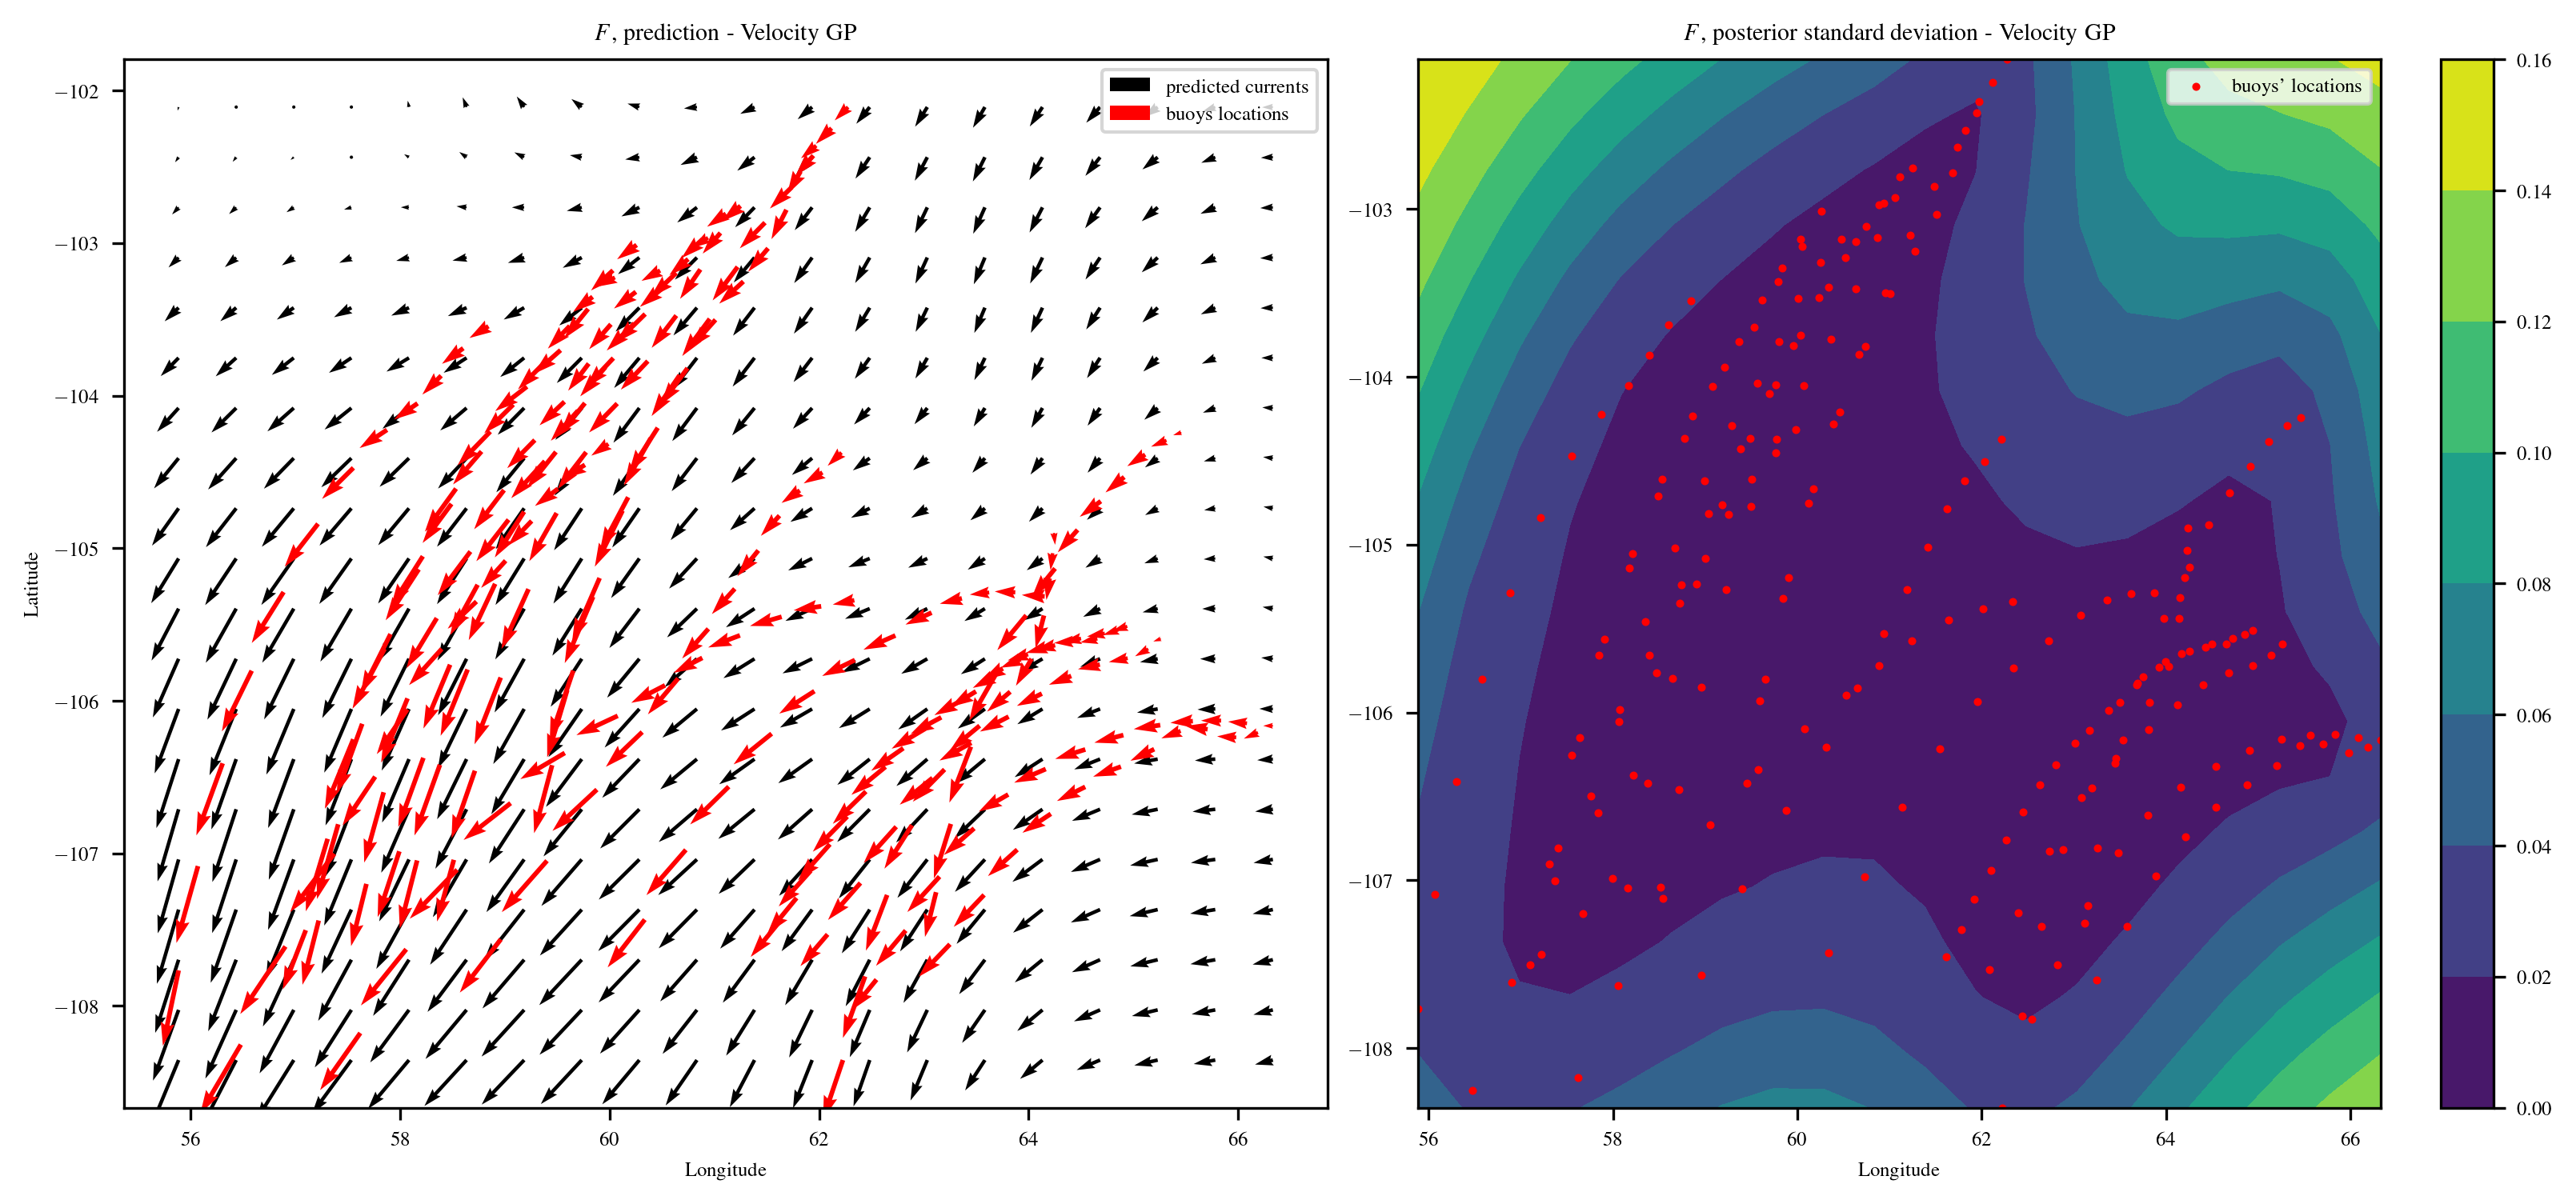

In [28]:
opt_post_mean_uv, opt_post_cov_uv, opt_ll_uv = hrp.posterior_kernel_twodata(XY_test, XY_test, UV_train, XY_train, "standard", params_uv)

plot_helm.plot_results_grid(X_grid, Y_grid, XY_train, UV_train, opt_post_mean_uv, opt_post_cov_uv, levels=False, scale=0.5, method="Velocity GP")


### 5. Visually compare velocity field predictions

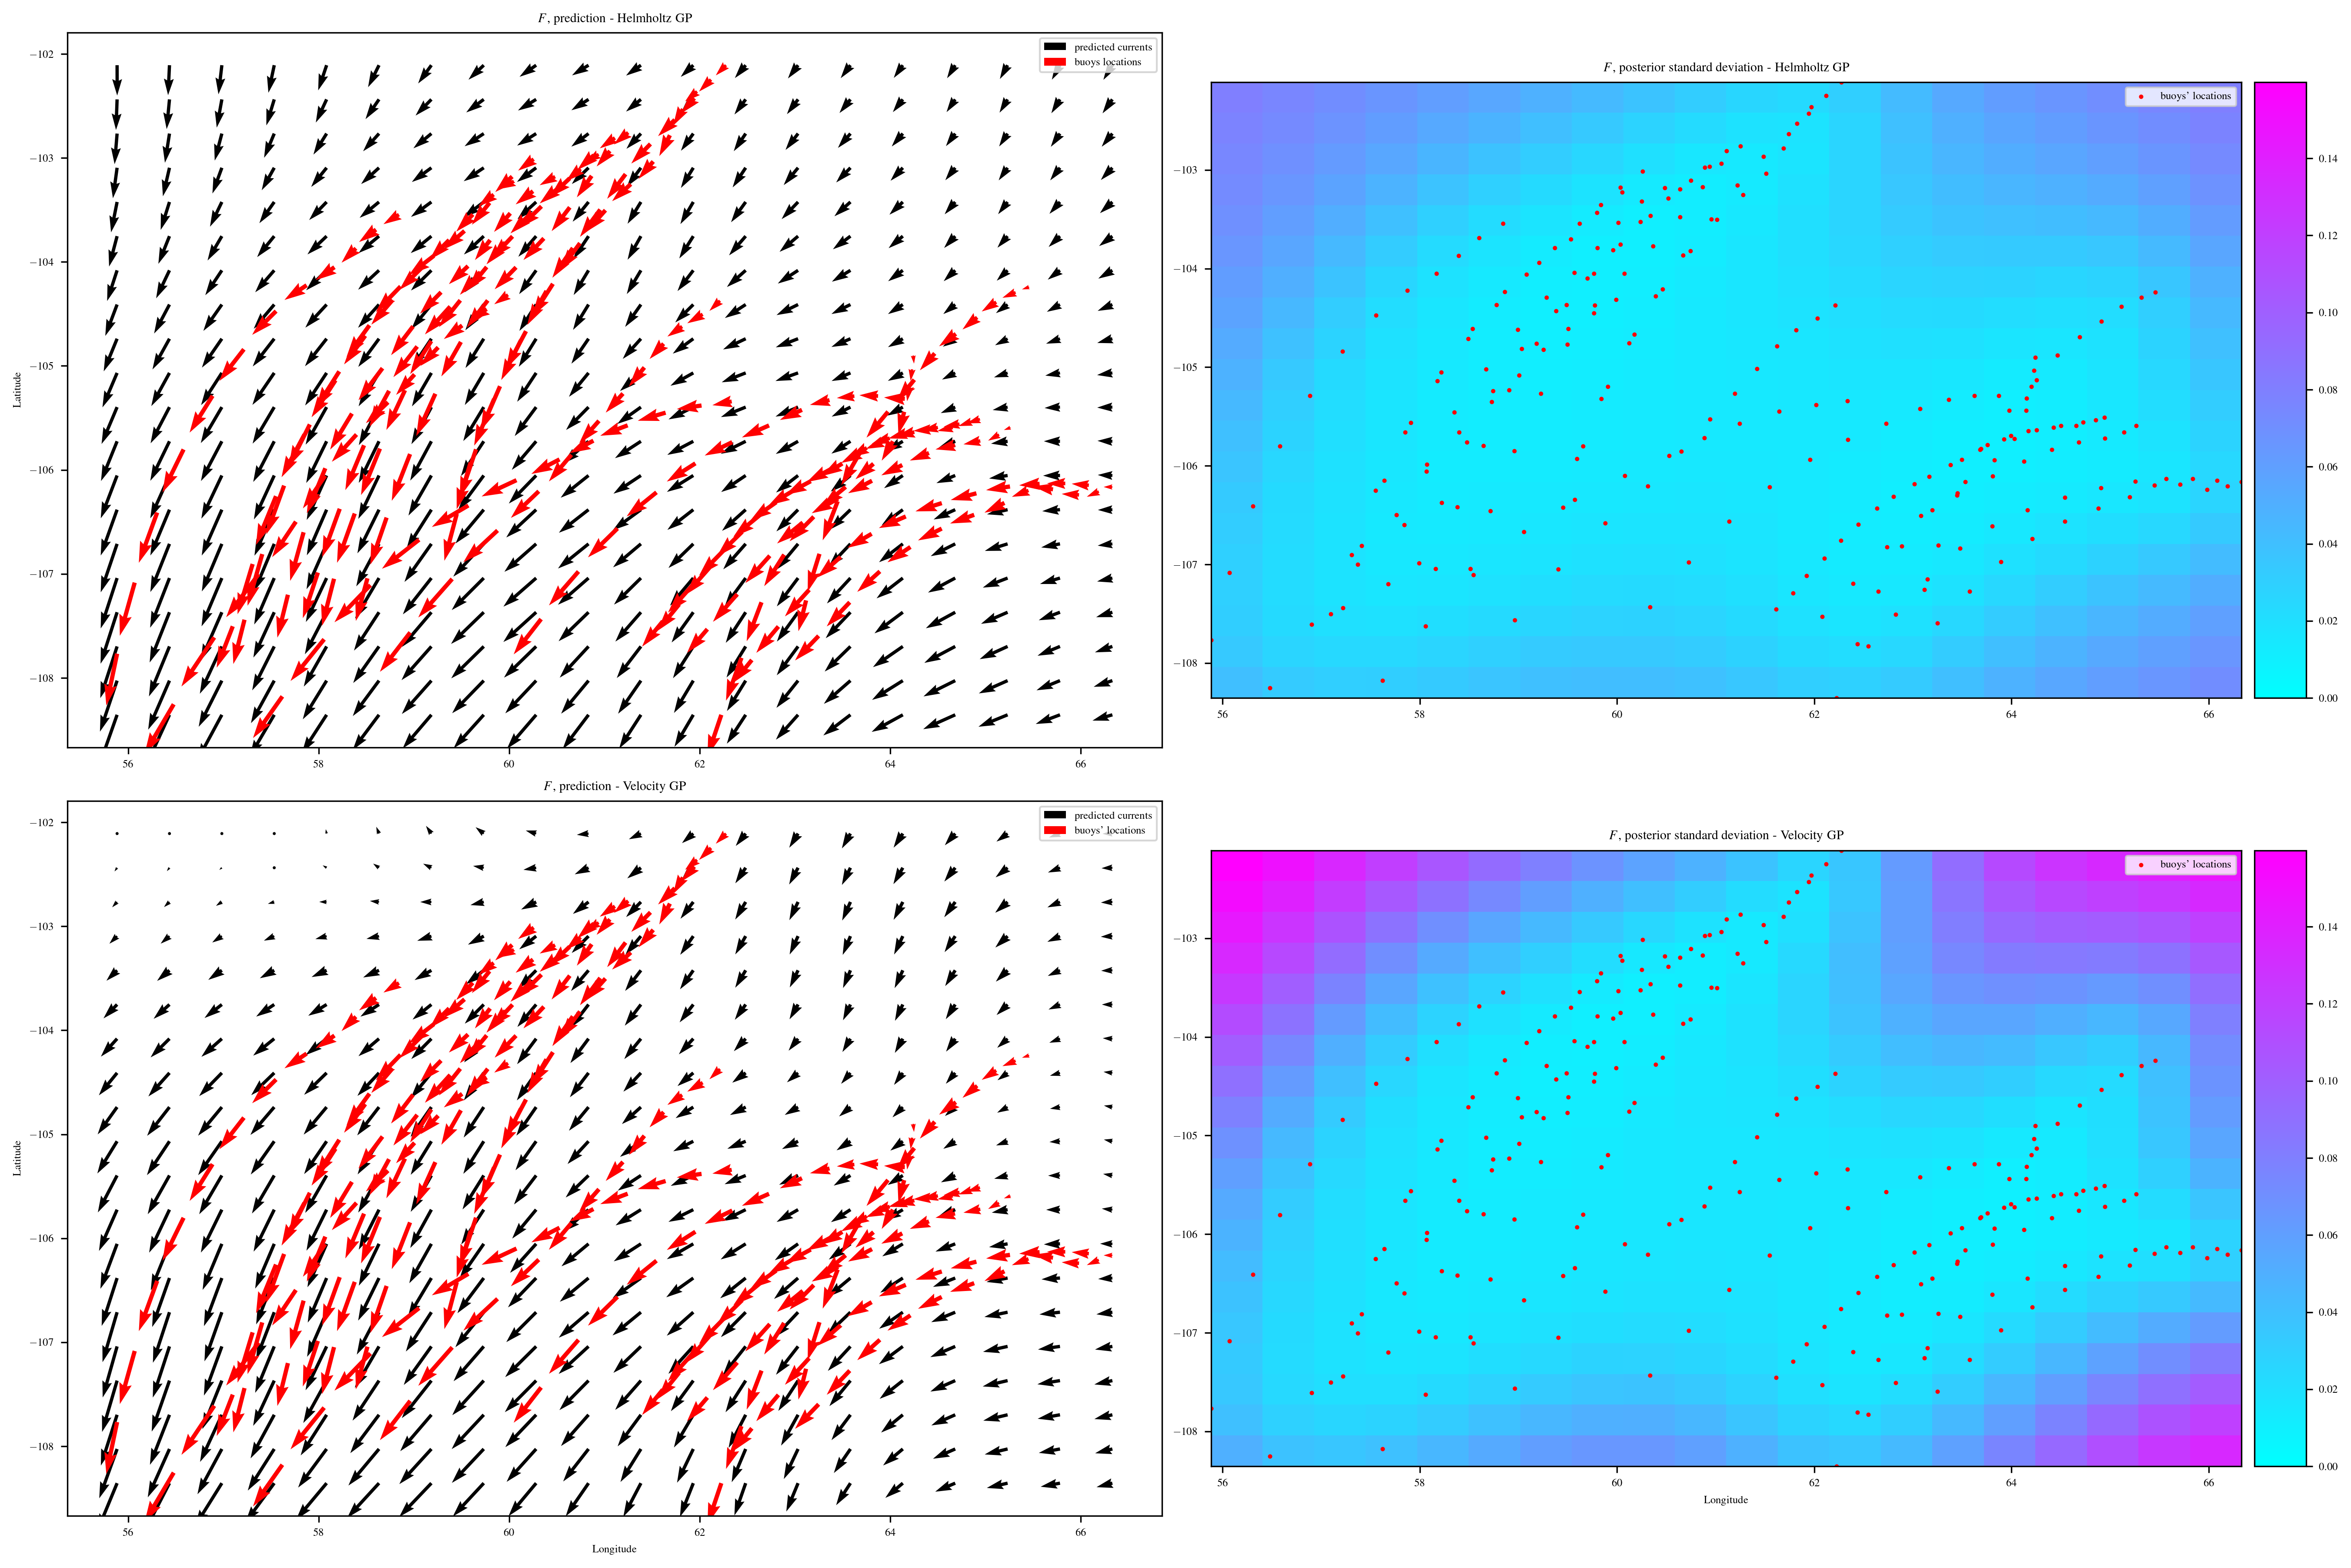

In [27]:
plot_helm.plot_results_comparison_realdata(X_grid, Y_grid, XY_train, UV_train, 
                                            opt_post_mean_helm, opt_post_cov_helm,
                                            opt_post_mean_uv, opt_post_cov_uv,
                                            scale=0.5, cmap='cool')
                                        

### 6. Posterior divergence analysis

We compute the posterior divergence for both methods, and we visually compare the predictions, uncertainty, and z-values.

In [13]:
div_mean_helm, div_var_helm = hrp.posterior_divergence_forloop_diffphi(XY_test, XY_train, UV_train, params_helm)
div_mean_std, div_var_std = hrp.posterior_divergence_forloop(XY_test, XY_train, UV_train, "standard", params_uv)

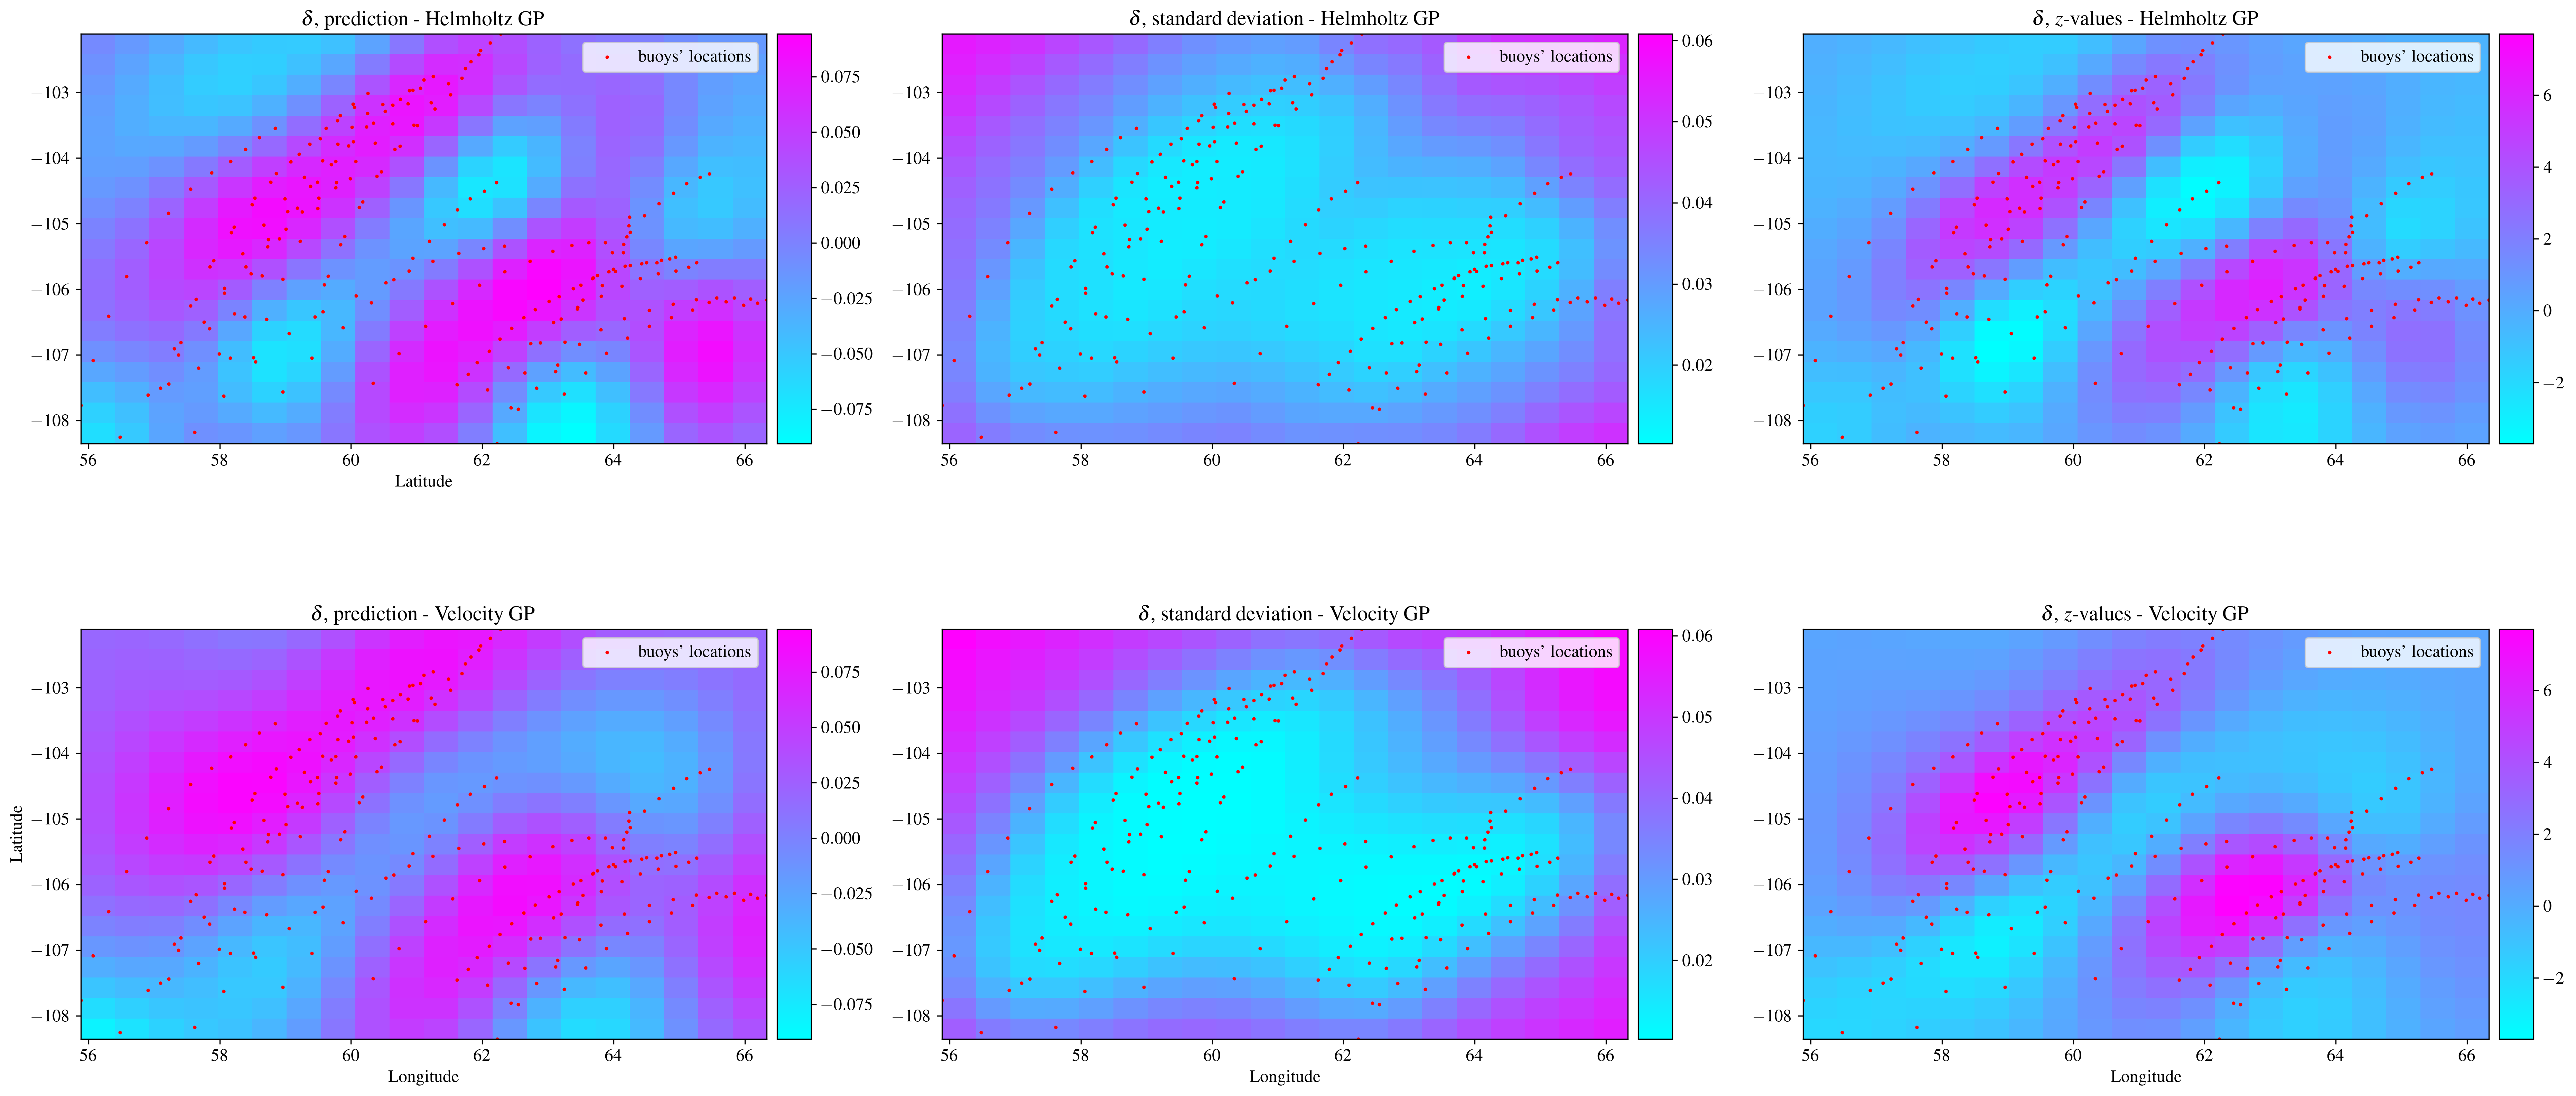

In [14]:
plot_helm.plot_scalarfield_comparison_realdata(X_grid, Y_grid, XY_train,
                                                div_mean_helm, div_var_helm,
                                                div_mean_std, div_var_std, 
                                                component="$\delta$", cmap='cool')

### 7. Compute posterior vorticity

Similarly we compute the vorticity and plot the results.

In [15]:
vort_mean_helm, vort_var_helm = hrp.posterior_vorticity_forloop_diffpsi(XY_test, XY_train, UV_train, params_helm)
vort_mean_std, vort_var_std = hrp.posterior_vorticity_forloop(XY_test, XY_train, UV_train, "standard", params_uv)

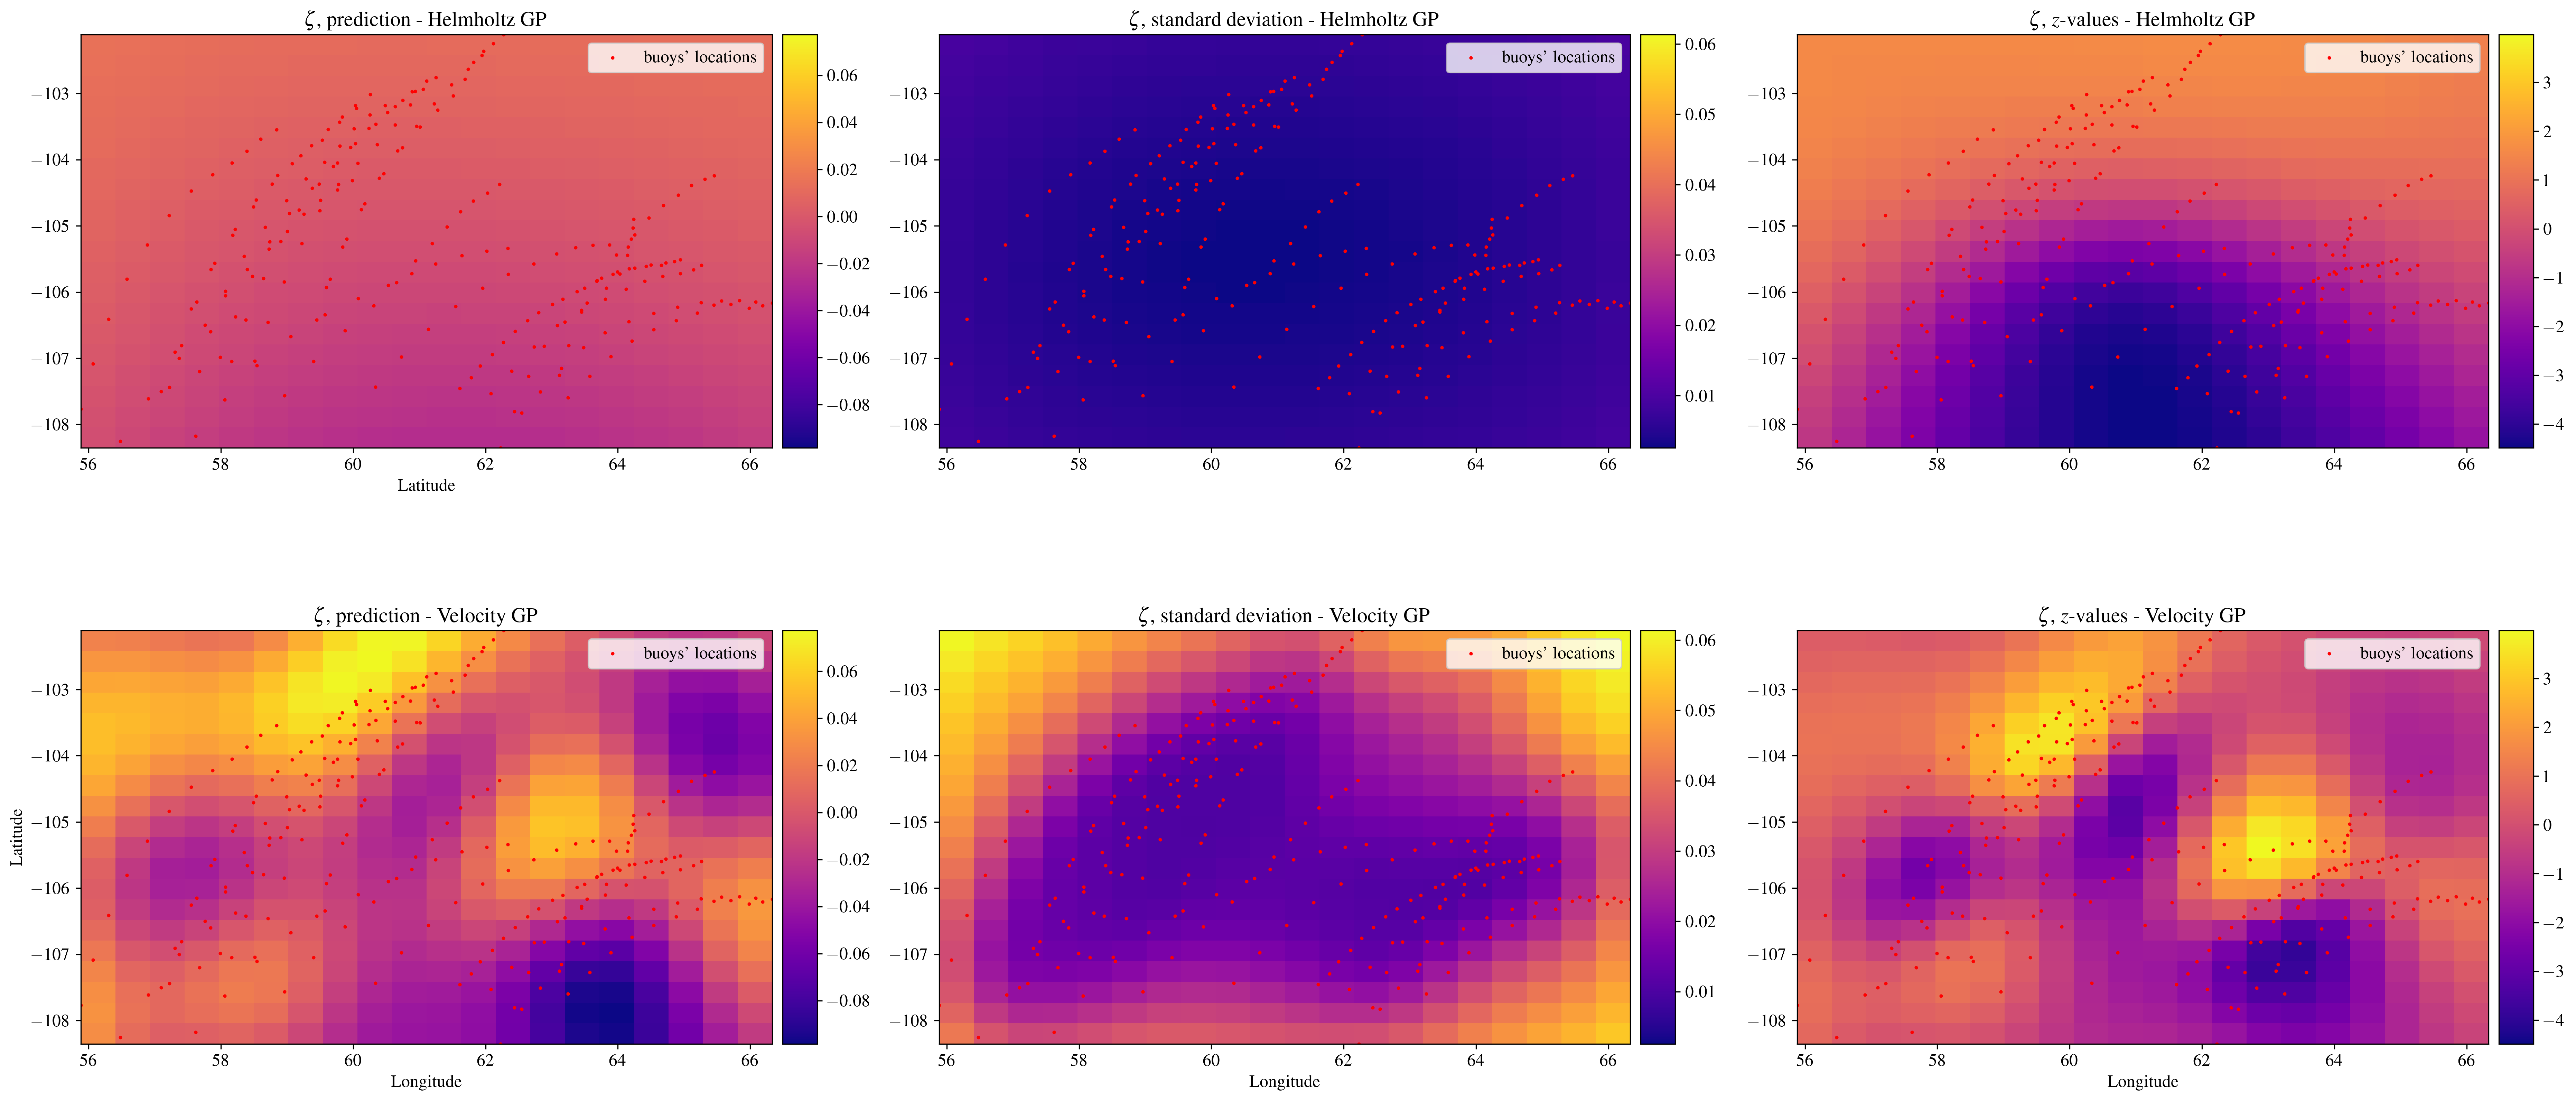

In [16]:
plot_helm.plot_scalarfield_comparison_realdata(X_grid, Y_grid, XY_train,
                                                vort_mean_helm, vort_var_helm,
                                                vort_mean_std, vort_var_std, 
                                                component="$\zeta$", cmap='plasma')

### 8. Get D-HNN predictions

Next, we can get the same set of results with the dissipative Hamiltonian neural network (D-HNN) approach

In [17]:
data = {'x':XY_train,
       'x_test':XY_test,
       't':np.reshape(np.ones(XY_train.shape[0]).T, [-1,1]),
       't_test':np.reshape(np.ones(XY_test.shape[0]).T, [-1,1]),
       'dx':UV_train, 
       'dx_test': np.reshape(np.ones(XY_test.shape[0]).T, [-1,1])
       }

In [19]:
args = get_args()
args.learning_rate = 3e-5
args.total_steps = 50000
args.eval_every = args.print_every = 1000

args.input_dim = 3
args.device = 'cpu'
[f(args.seed) for f in [np.random.seed, torch.manual_seed, torch.cuda.manual_seed_all]]
dhnn_model = DHNN(args.input_dim, args.hidden_dim)
dhnn_results = train(dhnn_model, args, data)  # training the model

step 0, dt 0.018, train_loss 9.00e-03, test_loss 9.92e-01
step 1000, dt 4.655, train_loss 9.61e-04, test_loss 1.27e+00
step 2000, dt 4.229, train_loss 1.15e-03, test_loss 1.27e+00
step 3000, dt 4.517, train_loss 1.42e-03, test_loss 1.27e+00
step 4000, dt 4.029, train_loss 9.62e-04, test_loss 1.27e+00
step 5000, dt 4.152, train_loss 1.15e-03, test_loss 1.27e+00
step 6000, dt 3.782, train_loss 1.41e-03, test_loss 1.27e+00
step 7000, dt 3.688, train_loss 9.62e-04, test_loss 1.27e+00
step 8000, dt 3.884, train_loss 1.15e-03, test_loss 1.27e+00
step 9000, dt 3.851, train_loss 1.41e-03, test_loss 1.27e+00
step 10000, dt 3.773, train_loss 9.60e-04, test_loss 1.27e+00
step 11000, dt 3.811, train_loss 1.14e-03, test_loss 1.27e+00
step 12000, dt 3.756, train_loss 1.40e-03, test_loss 1.27e+00
step 13000, dt 3.841, train_loss 9.58e-04, test_loss 1.27e+00
step 14000, dt 3.726, train_loss 1.14e-03, test_loss 1.27e+00
step 15000, dt 3.835, train_loss 1.39e-03, test_loss 1.27e+00
step 16000, dt 3.728,

In [20]:
##Visualize results
[x, x_test, t, t_test] = [torch.tensor(data[v], requires_grad=True,  dtype=torch.float32)
               for v in ['x', 'x_test','t', 't_test']]

#compute predictions at test points
y_hat_irr_test, y_hat_rot_test = dhnn_model(x_test, t=t_test, as_separate=True)
y_hat_test = y_hat_rot_test + y_hat_irr_test

#divergence at test point
divergence_x = torch.autograd.grad(y_hat_irr_test[:,0].sum(), x_test, create_graph=True)[0][:,0]
divergence_y = torch.autograd.grad(y_hat_irr_test[:,1].sum(), x_test, create_graph=True)[0][:,1]
divergence_dhnn = divergence_x + divergence_y

#vorticity at test point
vorticity_x = torch.autograd.grad(y_hat_rot_test[:,0].sum(), x_test, create_graph=True)[0][:,1]
vorticity_y = torch.autograd.grad(y_hat_rot_test[:,1].sum(), x_test, create_graph=True)[0][:,0]
vorticity_dhnn = vorticity_x - vorticity_y

/var/folders/xd/gc1qb67x67gbhkz1mmb7vbg40000gn/T/ipykernel_40544/4211146855.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [x, x_test, t, t_test] = [torch.tensor(data[v], requires_grad=True,  dtype=torch.float32)


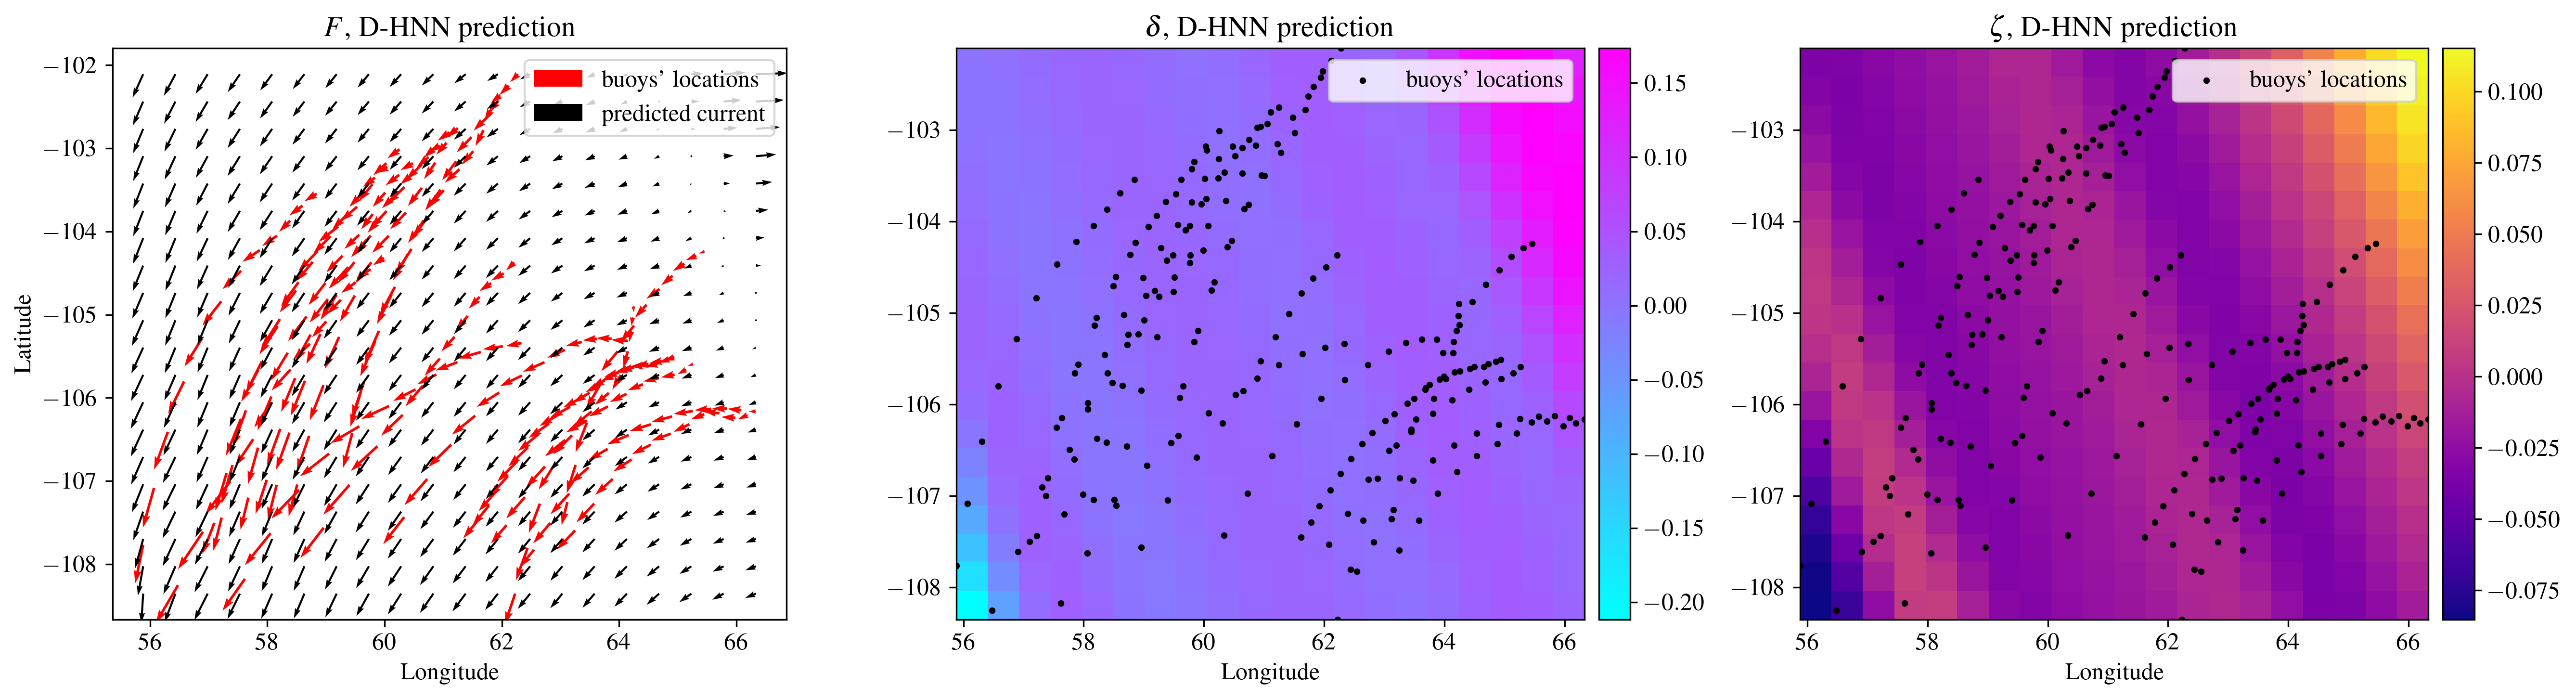

In [21]:
plot_helm.visualize_dhnn_results(X_grid, Y_grid, XY_train, UV_train, XY_test, y_hat_test, vorticity_dhnn, divergence_dhnn, cmap_div='cool', cmap_vort='plasma')

### 9. Plot for the main paper: predicted velocity field & divergence

In [22]:
plt.rcParams.update(
        {
            "text.usetex": True,
            "font.family": "serif",
            "font.serif": ["Times"],
            "font.size": 6,
        }
    )

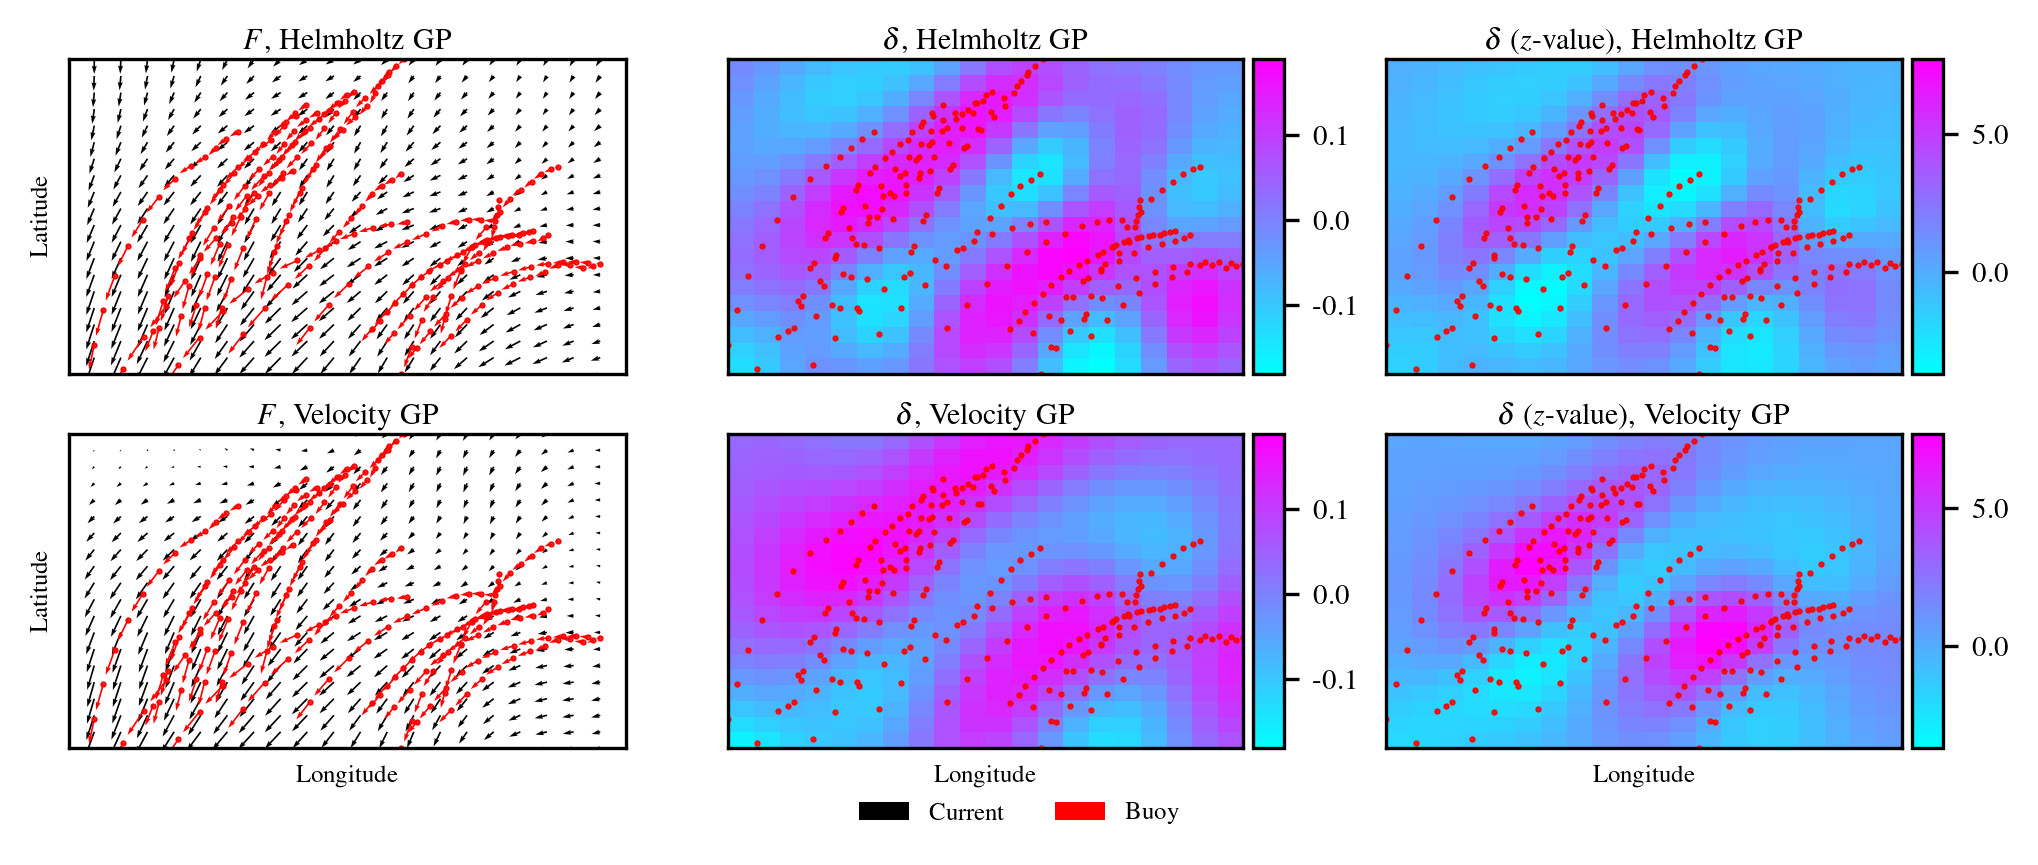

In [26]:
plot_helm.plot_results_paper_realdata(X_grid, Y_grid, XY_train, UV_train,
                                    opt_post_mean_helm, opt_post_cov_helm, 
                                    opt_post_mean_uv, opt_post_cov_uv,
                                    div_mean_helm, div_var_helm, 
                                    div_mean_std, div_var_std, cmap='cool', scale=0.5)

### 10. Plots for the appendix

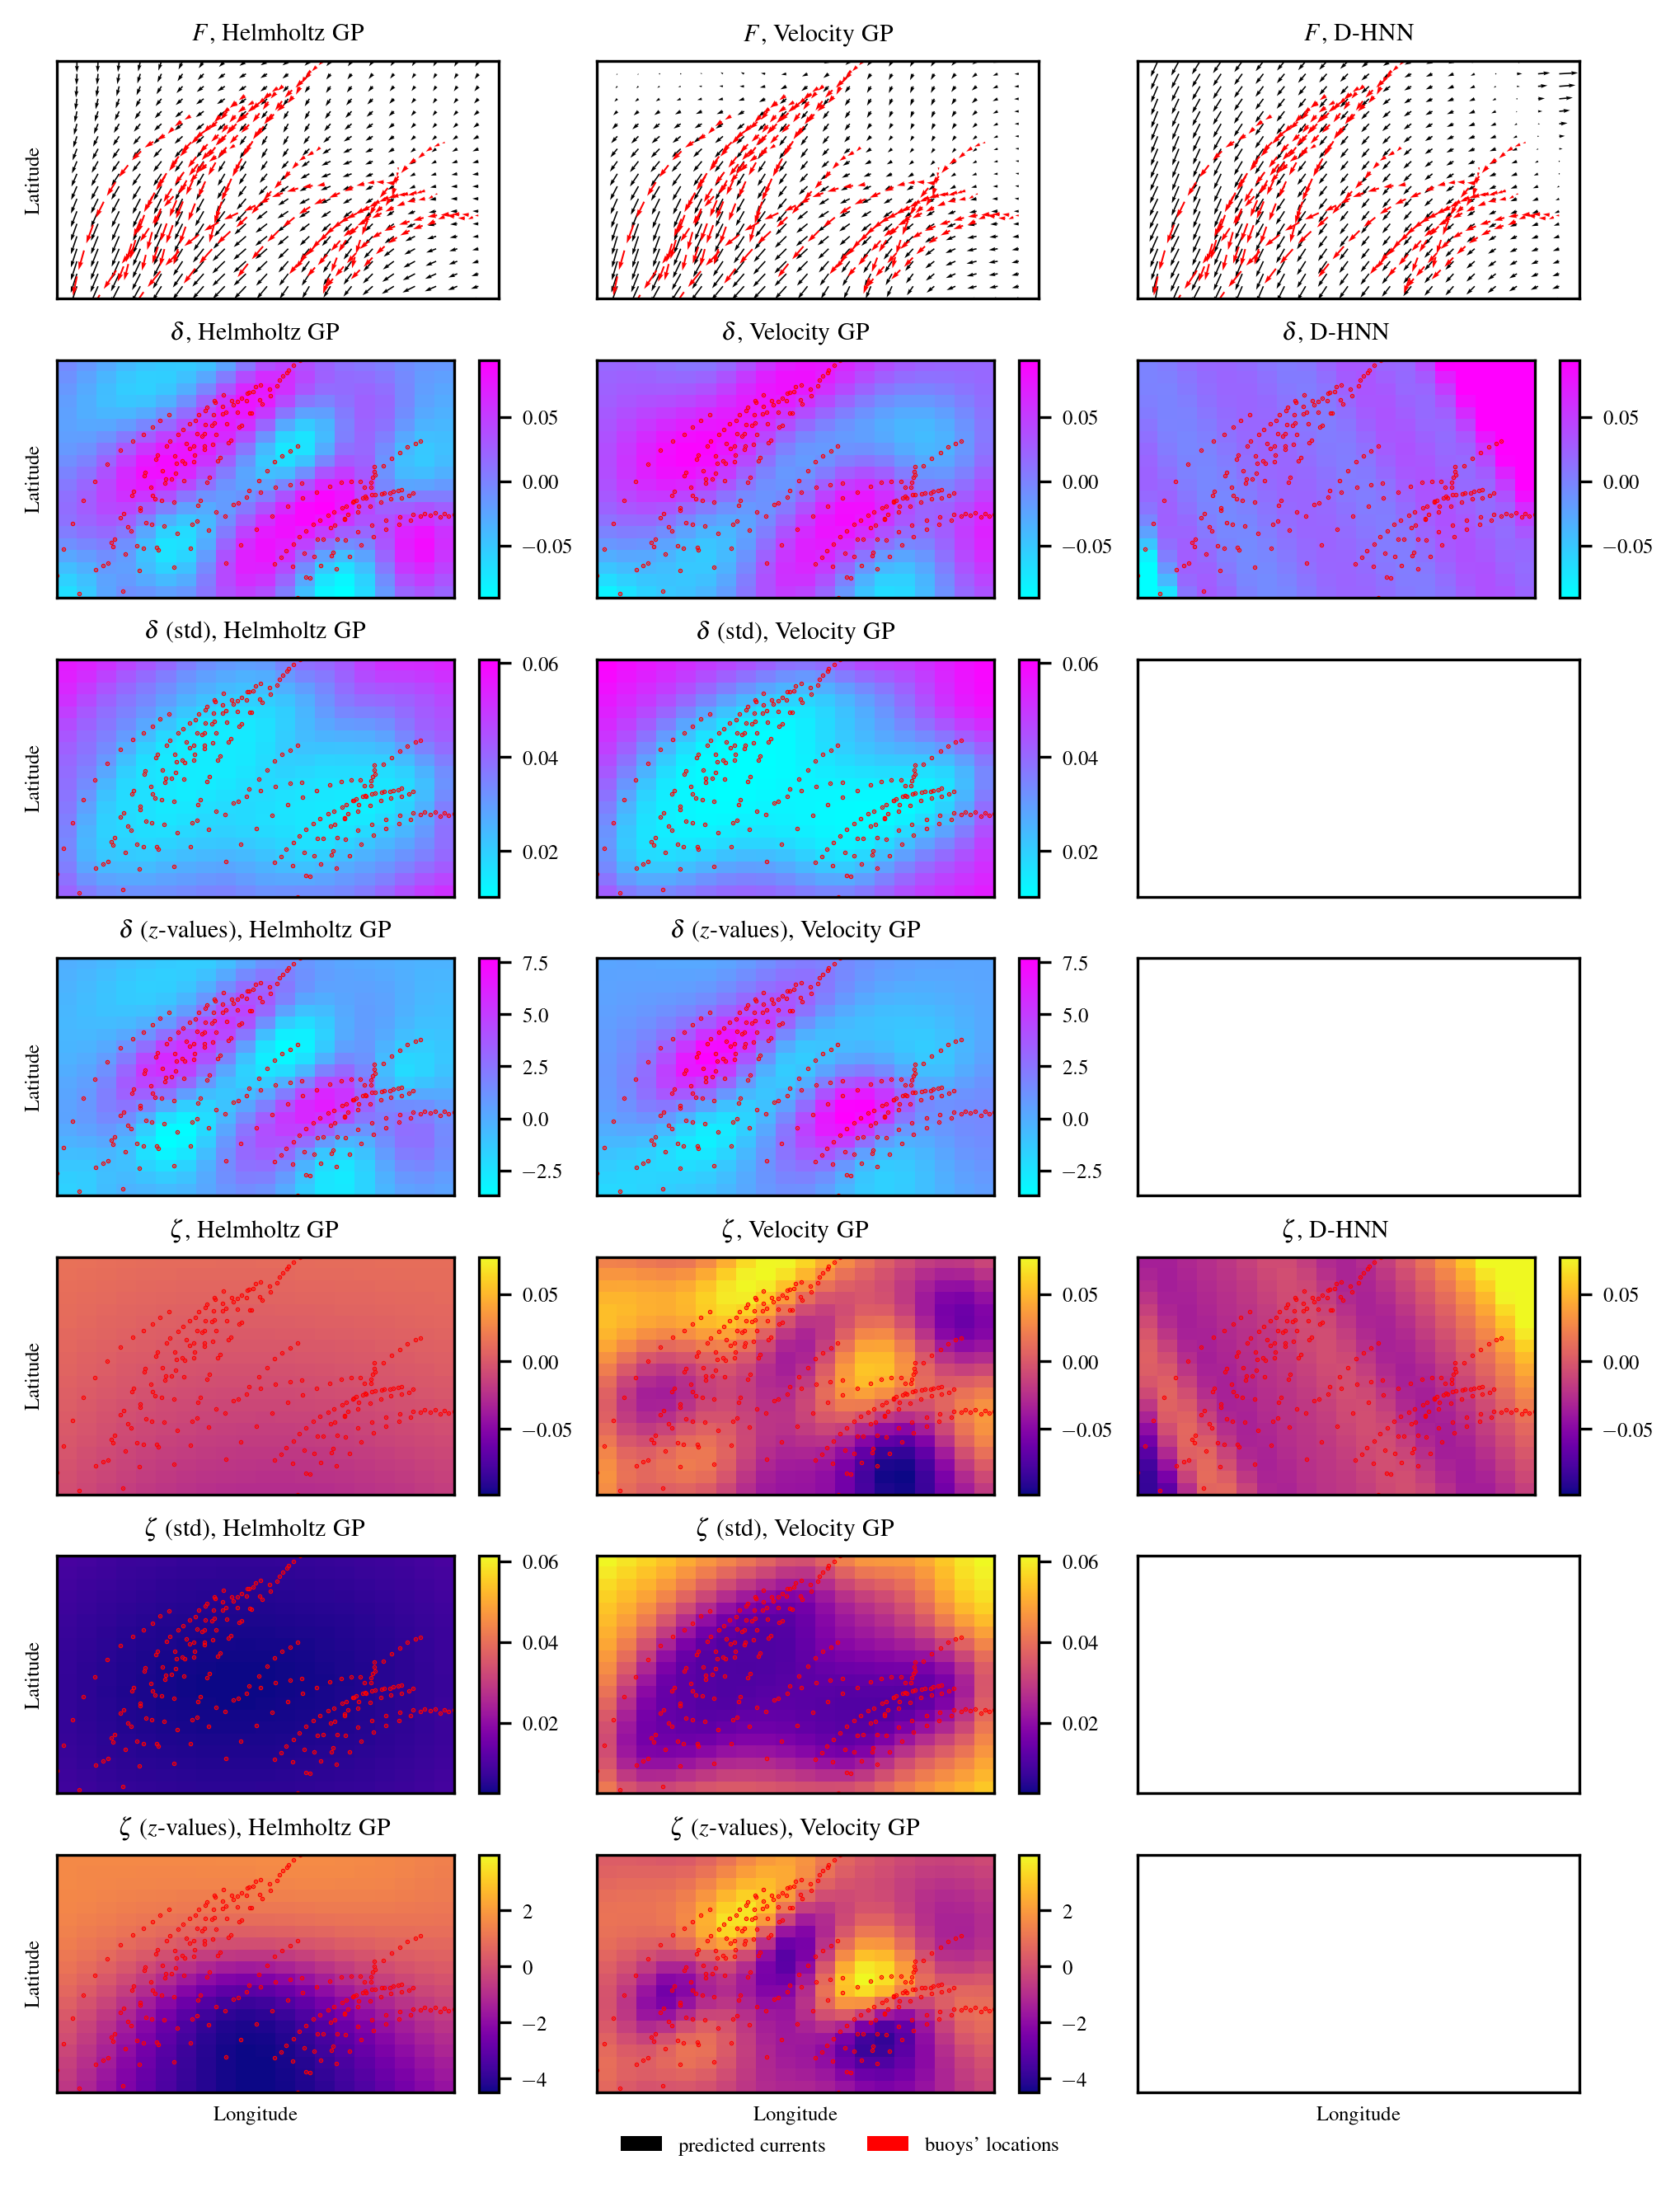

In [25]:
plot_helm.plot_appendix_results_realdata(X_grid, Y_grid, XY_train, UV_train,
                                        opt_post_mean_helm, opt_post_cov_helm, 
                                        opt_post_mean_uv, opt_post_cov_uv, 
                                        div_mean_helm, div_var_helm, 
                                        div_mean_std, div_var_std, 
                                        vort_mean_helm, vort_var_helm, 
                                        vort_mean_std, vort_var_std,
                                        y_hat_test, 
                                        divergence_dhnn, vorticity_dhnn, 
                                        cmap='cool', cmap_vort='plasma', scale=0.5, save_dest = "../plots_arxiv/laser_full_appendix")